# Facial Emotion Classifier

## Import the General Libraries

In [35]:
import numpy as np
import matplotlib.pyplot as plt

## Import the Relevant Image Libraries

In [36]:
import joblib  # Import joblib for saving and loading images

## Load the CNN Ready Train and Test Images Dataset

In [37]:
#Func to display a single image
def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')  # Hide axes
    plt.show()

In [38]:
# Load the cached images dataset
img_train = joblib.load('CNN_ready_img_train.pkl')
img_val = joblib.load('CNN_ready_img_val.pkl')
img_test = joblib.load('CNN_ready_img_test.pk1')

print("train df size = ", len(img_train))
print("val df size = ", len(img_val))
print("test df size = ", len(img_test))
# Checking the unit data in the dataset
print(f'Loaded cached images of shape {img_train[0][0].shape}')
print(f'Target of the image = {img_train[0][1]}')

train df size =  44441
val df size =  11111
test df size =  13657
Loaded cached images of shape (48, 48)
Target of the image = sad


## Splitting into Dataset to Features and Labels

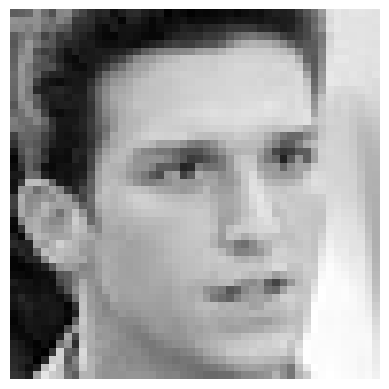

In [39]:
#Prepare the Dataset for splitting
# Separate the data into images and labels datasets
img_train_features = [item[0] for item in img_train]  # List of images (each image is a NumPy array)
img_train_labels = [item[1] for item in img_train]  # List of labels

img_val_features = [item[0] for item in img_val]  
img_val_labels = [item[1] for item in img_val]  


img_test_features = [item[0] for item in img_test]  
img_test_labels = [item[1] for item in img_test]  

show_image(img_train_features[10])

## One Hot Encoding of Targets

In [40]:
#Unique emtion classes
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Create a mapping of class name to index
class_to_index = {emotion: index for index, emotion in enumerate(emotion_classes)}
print(class_to_index)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5, 'neutral': 6}


In [41]:
#Convert train, val and test targets from string to indices.
train_labels_indices = [class_to_index[label] for label in img_train_labels]
val_labels_indices = [class_to_index[label] for label in img_val_labels]
test_labels_indices = [class_to_index[label] for label in img_test_labels]

print("Unique train target indices: ", np.unique(train_labels_indices))  
print("Unique val target indices: ", np.unique(val_labels_indices))  
print("Unique test target indices: ", np.unique(test_labels_indices))  

Unique train target indices:  [0 1 2 3 4 5 6]
Unique val target indices:  [0 1 2 3 4 5 6]
Unique test target indices:  [0 1 2 3 4 5 6]


In [42]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the train, val and test labels
train_labels_onehot = to_categorical(train_labels_indices, num_classes=len(emotion_classes))
val_labels_onehot = to_categorical(val_labels_indices, num_classes=len(emotion_classes))
test_labels_onehot = to_categorical(test_labels_indices, num_classes=len(emotion_classes))
# Print the one-hot encoded labels
print(train_labels_onehot)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


## Splitting the Training Dataset into Train and Validation sets

In [43]:
from sklearn.utils import shuffle

#Split X_train_full into training and validation sets
X_train, y_train = shuffle(img_train_features, train_labels_onehot)
X_val, y_val = shuffle(img_val_features, val_labels_onehot)
X_test, y_test = shuffle(img_test_features, test_labels_onehot)

[1. 0. 0. 0. 0. 0. 0.]


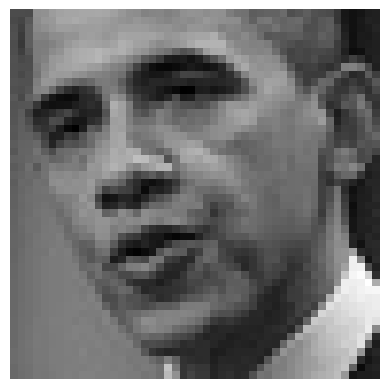

In [44]:
i = 90
print(y_train[i])
show_image(X_train[i])

## Converting the Data to Tensors Before CNN

In [45]:
import tensorflow as tf

# Convert each set to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Batch and prefetch datasets
batch_size = 32

train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Building the Model

In [46]:
from tensorflow.keras import layers, models

#num_emotion_classes to match number of emotion.
num_emotion_classes = len(emotion_classes)
# Define the CNN architecture
model = models.Sequential([
    #32 3x3 kernel filters applied to the 48x48x1 image. Produces 48x48x32 feature maps. 48x48 as a result of Stride = 1 and padding = same as default.
    #Relu activates on more prominent features.
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1), padding='same'), 
    #BatchNormalization helps model learn better by normalizing the activations results and reducing internal covariate shift.
    layers.BatchNormalization(),
    #64 (3x3 kernel filters) applied to the 48x48x32 feature maps. 1 of the 64 3x3 is applied to each of the 32 feature map. 
    #The result is a 32(48x48)(after stride=1 and same padding).
    #The result is summed up pixel-wise resulting in 48x48x1. The process is repeated 63 more times resulting in 48x48x64.
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'), 
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'), 
    layers.BatchNormalization(),
    
    #reduces the image dim by a factor of 2, feature maps are now 24x24x32 and selects and preserves pixels with prominent features 
    layers.MaxPooling2D((2, 2)),
    #Dropout helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time,
    #which forces the model to learn more robust features.
    layers.Dropout(0.2),
    
    #input:24x24x64 output:12x12x128
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu',padding='same'), 
    layers.BatchNormalization(),
    #reduces the image dim by a factor of 2, feature maps are now 12x12x64
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    #input:12x12x128 output:6x6x128
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'), 
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    #input:6x6x128 output:6x6x256
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'), 
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    #Converts to a vector of 6x6x256 = 9216
    layers.Flatten(),
    #Hidden layer of 64 nodes.
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    #Hidden layer of 64 nodes.
    layers.Dense(64, activation='relu'),
    #Softmax for classification.
    layers.Dense(num_emotion_classes, activation='softmax')  
])



# Compile the model
model.compile(optimizer="Adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\jcasu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Training the Model

In [47]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

#This scheduler will reduce the learning rate when the validation loss plateaus.
# Define ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

#Early stopping will help prevent overfitting by stopping the training when the validation loss stops improving.
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset, 
                    callbacks=[early_stopping, lr_scheduler]) 

# no lr scheduler
#round 10 accuracy: 0.6858 - loss: 0.8208 - val_accuracy: 0.5549 - val_loss: 1.3373
#-----------------------------------------------------------------------------------
#train and val= flipped only and data balanced
# no lr scheduler
#conv2D dropout = from 0.1 to 0.2
#dense dropout = from 0.2 to 0.3
#round 10 accuracy: 0.7262 - loss: 0.7452 - val_accuracy: 0.7188 - val_loss: 0.8142
#-----------------------------------------------------------------------------------
#train and val= flipped only and data balanced
# lr scheduler is now present
#conv2D dropout = from 0.1 to 0.2
#dense dropout = from 0.2 to 0.3
# round 10 accuracy: 0.7291 - loss: 0.7277 - val_accuracy: 0.7206 - val_loss: 0.8037 - learning_rate: 0.0010
#-----------------------------------------------------------------------------------
#train and val = rotated and then flipped and data balanced
# No padding after rotating
# lr scheduler is now present
#conv2D dropout = from 0.1 to 0.2
#dense dropout = from 0.2 to 0.3
#epoch = 30
#Round 15  accuracy: 0.8240 - loss: 0.4717 - val_accuracy: 0.7142 - val_loss: 0.9704 - learning_rate: 5.0000e-04
#-----------------------------------------------------------------------------------
#train and val = rotated and then flipped and data balanced
# padding (5 pixels on each side) present after rotating. resize done after padding.
# lr scheduler is now present
#conv2D dropout = from 0.1 to 0.2
#dense dropout = from 0.2 to 0.3
#epoch = 20
#round 16/20 accuracy: 0.7861 - loss: 0.5740 - val_accuracy: 0.6547 - val_loss: 1.1803 - learning_rate: 5.0000e-04
#-----------------------------------------------------------------------------------
#train and val = rotated and then flipped and data balanced
# padding (5 pixels on each side) present before rotating. resize done after rotation.
# lr scheduler is now present
#conv2D dropout = from 0.1 to 0.2
#dense dropout = from 0.2 to 0.3
#epoch = 20
#Round 16/20 accuracy: 0.7717 - loss: 0.6078 - val_accuracy: 0.6553 - val_loss: 1.1451 - learning_rate: 5.0000e-04
#-----------------------------------------------------------------------------------
#train and val = rotated and then flipped and data balanced
# no padding
# lr scheduler is now present
#conv2D dropout = from 0.2 to 0.25
#dense 1 dropout = from 0.3 to 0.35
#another dense layer added(64)
#dense 2 dropout = 0.35
#early_stopping patience from 3 to 4
#epoch = 20
#round 20 accuracy: 0.7145 - loss: 0.7767 - val_accuracy: 0.6756 - val_loss: 0.9122 - learning_rate: 0.0010
#-----------------------------------------------------------------------------------
#train and val = rotated and then flipped and data balanced
# no padding
# lr scheduler is now present
#conv2D dropout = from 0.2 to 0.25
#dense 1 dropout = from 0.3 to 0.35
#another dense layer added(64)
#dense 2 dropout = 0.35
#early_stopping patience from 3 to 4
#optimizer=sgd lr: from 0.01 to 0.001 
#epoch = 30
#round 30 accuracy: 0.7569 - loss: 0.6549 - val_accuracy: 0.6944 - val_loss: 0.8730 - learning_rate: 5.0000e-
#-----------------------------------------------------------------------------------
#train and val = rotated and then flipped and data balanced
# No padding after rotating
# lr scheduler is now present
#conv2D dropout = from 0.25 to 0.2
#dense dropout = from 0.35 to 0.3
#dense 2 dropout = 0.3
#early_stopping patience from 3 to 4
#optimizer=adam
#epoch = 30
#round 23 accuracy: 0.8328 - loss: 0.4719 - val_accuracy: 0.7036 - val_loss: 1.0078 - learning_rate: 2.5000e-04
#-----------------------------------------------------------------------------------
#train and val = rotated and then flipped and data balanced
# No padding after rotating
# lr scheduler is now present
#conv2D dropout = from 0.25 to 0.2
#dense dropout = from 0.35 to 0.3
#added conv2D(64) before first maxpooling
#dense 2 dropout removed
#early_stopping patience from 3 to 4
#optimizer=adam
#epoch = 30
#round 19 accuracy: 0.8527 - loss: 0.4046 - val_accuracy: 0.7170 - val_loss: 0.9450 - learning_rate: 5.0000e-04
#-----------------------------------------------------------------------------------
#removed conv2D(64) before first maxpooling
#round 16 accuracy: 0.8078 - loss: 0.5136 - val_accuracy: 0.7064 - val_loss: 0.9145 - learning_rate: 5.0000e-04
#-----------------------------------------------------------------------------------
#added conv2D(64) before first maxpooling
#removed dense 2 layer
#round 15 accuracy: 0.7931 - loss: 0.5498 - val_accuracy: 0.7092 - val_loss: 1.0391 - learning_rate: 5.0000e-04
#-----------------------------------------------------------------------------------
#train and val = rotated and then flipped and data balanced
# No padding after rotating
# lr scheduler is now present
#conv2D dropout = from 0.25 to 0.2
#dense dropout = from 0.35 to 0.3
#added another dense(128) before flatten
#moved dense dropout from after first dense(128) to before softmax
#early_stopping patience from 3 to 4
#optimizer=adam
#epoch = 30
#round 15 accuracy: 0.8754 - loss: 0.3605 - val_accuracy: 0.7167 - val_loss: 1.1913 - learning_rate: 5.0000e-04
#-----------------------------------------------------------------------------------
#lr scheduler patience from 3 to 2
#early stopping patience from 4 to 5
#-----------------------------------------------------------------------------------
#train and val = rotated and then flipped and data balanced
#undid(added another dense(128) before flatten)
#undid(moved dense dropout from after first dense(128) to before softmax)
#Shuffled train, val and test
#epoch 17 accuracy: 0.8524 - loss: 0.4025 - val_accuracy: 0.7220 - val_loss: 0.9250 - learning_rate: 2.5000e-04
#epoch 21 accuracy: 0.9000 - loss: 0.2780 - val_accuracy: 0.7382 - val_loss: 0.9339 - learning_rate: 2.5000e-04
#epoch 20 accuracy: 0.8633 - loss: 0.3873 - val_accuracy: 0.7268 - val_loss: 0.9204 - learning_rate: 5.0000e-04
#avg train accuracy = 87.19
#avg train loss = 0.3559
#avg val accuracy = 72.9
#avg val loss = 0.9264


Epoch 1/30
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 459s 319ms/step - accuracy: 0.2643 - loss: 1.8364 - val_accuracy: 0.4163 - val_loss: 1.5370 - learning_rate: 0.0010
Epoch 2/30
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 399s 287ms/step - accuracy: 0.3956 - loss: 1.5314 - val_accuracy: 0.4513 - val_loss: 1.4183 - learning_rate: 0.0010
Epoch 3/30
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 398s 287ms/step - accuracy: 0.4538 - loss: 1.3871 - val_accuracy: 0.5018 - val_loss: 1.3119 - learning_rate: 0.0010
Epoch 4/30
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 397s 286ms/step - accuracy: 0.4976 - loss: 1.2894 - val_accuracy: 0.5359 - val_loss: 1.1972 - learning_rate: 0.0010
Epoch 5/30
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 399s 288ms/step - accuracy: 0.5312 - loss: 1.1966 - val_accuracy: 0.5597 - val_loss: 1.1645 - learning_rate: 0.0010
Epoch 6/30
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 399s 287ms/step - accuracy: 0.5681 - loss: 1.1135 - val_accuracy: 0.5956 - val_loss: 1.0883 - learning_rate: 0.0010
Epoch 7/30
1389/1389 ━━━━━━━━━━━━━━━━━━━━ 400s 288ms

## Plotting the Loss and Accuracy of the Train and Validation

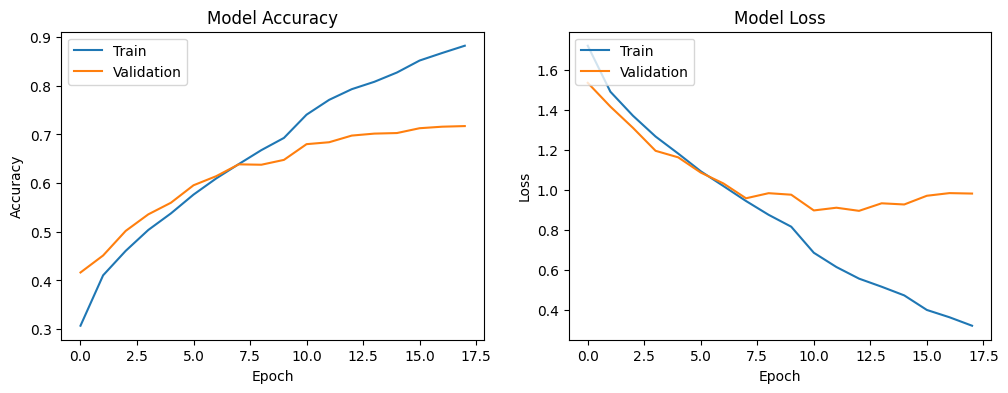

In [49]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


## Evaluating the Model on the Test Dataset

In [50]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
#For flipped images only
#427/427 ━━━━━━━━━━━━━━━━━━━━ 35s 80ms/step - accuracy: 0.6084 - loss: 1.6358


427/427 ━━━━━━━━━━━━━━━━━━━━ 29s 67ms/step - accuracy: 0.6265 - loss: 1.2068
Test Accuracy: 0.6271
Test Loss: 1.2200


## Predictions on Test Dataset

In [51]:
# Get predictions for the entire test dataset
predictions = model.predict(test_dataset)

# predict the  classes:
predicted_classes = np.argmax(predictions, axis=1)

# Compare with the true labels:
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)  
true_classes = np.argmax(true_labels, axis=1)

427/427 ━━━━━━━━━━━━━━━━━━━━ 29s 68ms/step


## Analyzing the Model's Predictions

Confusion matrix
------------------------
[[ 991   88  287   38  330   54  163]
 [ 208 1574   66    5   39   51    8]
 [ 248   47  767   32  497  195  165]
 [  61    1   51 1558  105   51  124]
 [ 224   18  256   60 1087   27  279]
 [  29   33  258   45   51 1488   47]
 [ 143   15  155   70  444   25 1099]]


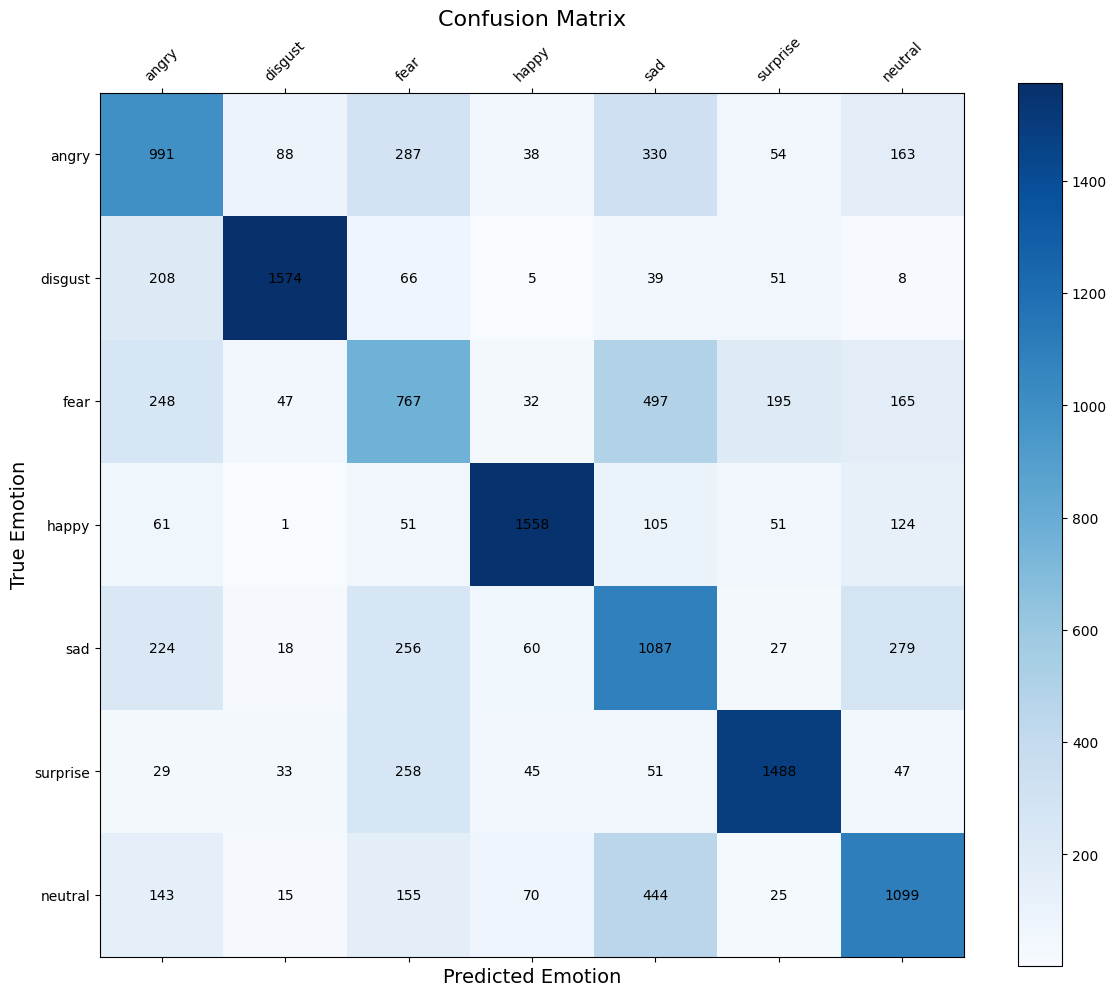

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create a confusion matrix using the true andpredicted classes.
conf_matrix = confusion_matrix(true_classes, predicted_classes)

#Print for verification
print("Confusion matrix")
print("------------------------")    
print(conf_matrix)

# Create the heatmap using Matplotlib
fig, ax = plt.subplots(figsize=(12, 10))  # Create a figure and axis for the plot
cax = ax.matshow(conf_matrix, cmap='Blues')  # Visualize the matrix using a 'Blues' colormap

# Add a color bar to show the scale of values
plt.colorbar(cax)

rows, cols = conf_matrix.shape  # Get the number of rows and columns in the confusion matrix
for i in range(rows):
    for j in range(cols):
        ax.text(j, i, f"{int(conf_matrix[i, j])}",  # Add text annotations
                ha='center', va='center', #Horizontal and vertical allignment for the text
                color='black', fontsize=10)


# Set axis labels and ticks
ax.set_xticks(np.arange(cols))  # Set tick positions for the x-axis
ax.set_yticks(np.arange(rows))  # Set tick positions for the y-axis
ax.set_xticklabels(['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'], rotation=45, fontsize=10) #Rotated for improved readability.
ax.set_yticklabels(['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'], fontsize=10)

# Add axis labels and a title
ax.set_xlabel('Predicted Emotion', fontsize=14)
ax.set_ylabel('True Emotion', fontsize=14)
ax.set_title('Confusion Matrix', fontsize=16)

# Adjust the layout to avoid overlapping labels
plt.tight_layout()
plt.show()


## Model Metrics

In [53]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming true_classes and predicted_classes contain your true and predicted labels
# Example: true_classes = [0, 1, 2, ...] , predicted_classes = [0, 0, 1, ...]

# Calculate precision, recall, F1 score, and accuracy
precision = precision_score(true_classes, predicted_classes, average='weighted')  # weighted average for multi-class classification
recall = recall_score(true_classes, predicted_classes, average='weighted')  # weighted average for multi-class classification
f1 = f1_score(true_classes, predicted_classes, average='weighted')  # weighted average for multi-class classification
accuracy = accuracy_score(true_classes, predicted_classes)

# Print the metrics
print(f"Precision: {100*precision:.4f}")
print(f"Recall: {100*recall:.4f}")
print(f"F1 Score: {100*f1:.4f}")
print(f"Accuracy: {100*accuracy:.4f}")
#For flipped images only
#Precision: 64.3121
#Recall: 61.0969
#F1 Score: 61.9513
#Accuracy: 61.0969

Precision: 64.0143
Recall: 62.7078
F1 Score: 63.1806
Accuracy: 62.7078


## Saving the Model

In [54]:
#model.save('path_to_save_model/my_model.h5')
# OR
#model.save('my_model.keras')
model.save('FRmodel2.keras')